## Import Libraries and Mount Google Drive

In [ ]:
import pandas as pd
import numpy as np
import progressbar
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout, Dense, Input
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Load the Data

In [ ]:
# Load the GO terms with their corresponding proteins and the IA weights
train_terms_path = '/content/drive/My Drive/DATASET/Train/train_terms.tsv'
train_terms = pd.read_csv(train_terms_path, delimiter='\t')

ia_path = '/content/drive/My Drive/DATASET/IA.txt'
ia_data = pd.read_csv(ia_path, sep='\t', names=['term', 'importance'])


## Merge Data and Select Top Terms

In [ ]:
# Merge the GO terms data with the importance scores
train_terms = train_terms.merge(ia_data, on='term')

# Sort by importance and select the top 1500 unique terms
top_terms = train_terms.sort_values(by='importance', ascending=False).drop_duplicates('term').head(1500)

# Filter train_terms to include only the top 1500 terms
filtered_terms = train_terms[train_terms['term'].isin(top_terms['term'])]

## Create Label DataFrame

In [ ]:
# Load protein IDs
train_protids_path = '/content/drive/My Drive/DATASET/EMB/train_ids.npy'
train_protein_ids = np.load(train_protids_path)

def create_important_labels_df(protein_ids, terms, num_labels):
    """ Create a DataFrame for important labels based on the top terms. """
    labels = np.zeros((len(protein_ids), num_labels))
    series_protein_ids = pd.Series(protein_ids)

    # Initialize progress bar for tracking
    bar = progressbar.ProgressBar(maxval=num_labels, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()

    # Assign labels to proteins based on the presence of terms
    for i, term in enumerate(terms['term'].unique()):
        term_entries = terms[terms['term'] == term]
        related_proteins = term_entries['EntryID'].unique()
        labels[:, i] = series_protein_ids.isin(related_proteins).astype(float)
        bar.update(i + 1)

    bar.finish()
    return pd.DataFrame(data=labels, columns=terms['term'].unique())

# Create and save the DataFrame for important labels
important_labels_df = create_important_labels_df(train_protein_ids, filtered_terms, 1500)
important_labels_df_path = '/content/drive/My Drive/DATASET/important_labels_df.pkl'
important_labels_df.to_pickle(important_labels_df_path)
print("important_labels_df created and saved.")


[========================================================================] 100%


important_labels_df created and saved.


## Load and Split the Dataset

In [ ]:
# Paths to the files
path_train_embeds = '/content/drive/My Drive/DATASET/EMB/train_embeds.npy'
# Loading the data
train_embeds = np.load(path_train_embeds)
# Print the shape of the loaded data to confirm
print("Loaded data shape:", train_embeds.shape)

# converting embeddings numpy array(train_embeds) into pandas dataframe
column_num = train_embeds.shape[1]
train_df = pd.DataFrame(train_embeds, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)

train_df.head()

Loaded data shape: (142246, 1024)
(142246, 1024)


,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


In [ ]:

# Define the path to the pickle file
pickle_path = "/content/drive/My Drive/DATASET/important_labels_df.pkl"

# load labels_df from the pickle file
labels_df = pd.read_pickle(pickle_path)
print("Loaded labels_df from pickle.")


# Ensure train_embeds has the shape (num_samples, sequence_length, embedding_dim)
# Adding a new axis to have shape (142246, 1024, 1)
train_embeds = np.expand_dims(train_embeds, axis=-1)

# Proceed with splitting the datasets
# First, split the data into a training set and a temporary testing set
X_train, X_temp, y_train, y_temp = train_test_split(
    train_df, labels_df, test_size=0.2, random_state=42
)

# Next, split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Display the dimensions of the sets to verify proper splitting
print(f"Training set dimensions: {X_train.shape}, {y_train.shape}")
print(f"Validation set dimensions: {X_val.shape}, {y_val.shape}")
print(f"Test set dimensions: {X_test.shape}, {y_test.shape}")


Loaded labels_df from pickle.
Training set dimensions: (113796, 1024), (113796, 1500)
Validation set dimensions: (14225, 1024), (14225, 1500)
Test set dimensions: (14225, 1024), (14225, 1500)


## Evaluation of the Model with the new label dataframe

In [ ]:
INPUT_SHAPE = [X_train.shape[1]]
BATCH_SIZE = 500
num_of_labels= 1500
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_recall_curve, auc, average_precision_score
from tensorflow.keras.utils import plot_model
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),
    tf.keras.layers.Dense(units=1024, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(units=1000, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(units=512, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.Dense(units=num_of_labels, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()],
)

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val)
)



Epoch 1/20
228/228 [==============================] - 10s 16ms/step - loss: 0.2448 - binary_accuracy: 0.9936 - auc: 0.5010 - val_loss: 0.0187 - val_binary_accuracy: 0.9999 - val_auc: 0.5415
Epoch 2/20
228/228 [==============================] - 3s 13ms/step - loss: 0.0139 - binary_accuracy: 0.9999 - auc: 0.5036 - val_loss: 0.0123 - val_binary_accuracy: 0.9999 - val_auc: 0.6218
Epoch 3/20
228/228 [==============================] - 3s 13ms/step - loss: 8.5328e-04 - binary_accuracy: 0.9999 - auc: 0.5000 - val_loss: 0.0038 - val_binary_accuracy: 0.9999 - val_auc: 0.6903
Epoch 4/20
228/228 [==============================] - 3s 13ms/step - loss: 7.1007e-04 - binary_accuracy: 0.9999 - auc: 0.5001 - val_loss: 0.0017 - val_binary_accuracy: 0.9999 - val_auc: 0.5922
Epoch 5/20
228/228 [==============================] - 3s 13ms/step - loss: 6.7665e-04 - binary_accuracy: 0.9999 - auc: 0.5003 - val_loss: 7.5782e-04 - val_binary_accuracy: 0.9999 - val_auc: 0.5017
Epoch 6/20
228/228 [==================

In [ ]:
def evaluate_dnn_model(dnn_model, X_test, y_test):
    # Ensure the test sets are numpy arrays if they are DataFrames
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.values

    # Predict probabilities for each class using the DNN model
    y_pred_probs = dnn_model.predict(X_test)

    # Calculate precision and recall for each label
    precisions, recalls, thresholds = precision_recall_curve(y_test.ravel(), y_pred_probs.ravel())

    # Calculate Fmax
    f1_scores = 2 * (precisions * recalls) / (np.maximum(precisions + recalls, 1e-5))
    fmax = np.max(f1_scores)

    # Calculate AUPR
    aupr = auc(recalls, precisions)

    # Print results for DNN
    print(f"DNN - Fmax: {fmax}, AUPR: {aupr}")

# Example usage with the DNN model, X_test, and y_test assumed to be defined elsewhere
evaluate_dnn_model(model, X_test, y_test)


445/445 [==============================] - 1s 1ms/step
DNN - Fmax: 0.0020036064916850328, AUPR: 0.0003951654258448088


In [ ]:

# Define the path to the pickle file
pickle_path = "/content/drive/My Drive/DATASET/updated00_labels_df.pkl"

# load labels_df from the pickle file
labels_df = pd.read_pickle(pickle_path)
print("Loaded labels_df from pickle.")


# Ensure train_embeds has the shape (num_samples, sequence_length, embedding_dim)
# Adding a new axis to have shape (142246, 1024, 1)
train_embeds = np.expand_dims(train_embeds, axis=-1)

# Proceed with splitting the datasets
# First, split the data into a training set and a temporary testing set
X_train, X_temp, y_train, y_temp = train_test_split(
    train_df, labels_df, test_size=0.2, random_state=42
)

# Next, split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Display the dimensions of the sets to verify proper splitting
print(f"Training set dimensions: {X_train.shape}, {y_train.shape}")
print(f"Validation set dimensions: {X_val.shape}, {y_val.shape}")
print(f"Test set dimensions: {X_test.shape}, {y_test.shape}")


Loaded labels_df from pickle.
Training set dimensions: (113796, 1024), (113796, 1500)
Validation set dimensions: (14225, 1024), (14225, 1500)
Test set dimensions: (14225, 1024), (14225, 1500)


In [ ]:
INPUT_SHAPE = [X_train.shape[1]]
from tensorflow.keras.callbacks import ModelCheckpoint


# Définition de l'architecture du modèle
INPUT_SHAPE = [X_train.shape[1]]
BATCH_SIZE = 500
num_of_labels = 1500

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),
    tf.keras.layers.Dense(units=1024, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(units=1000, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(units=512, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.Dense(units=num_of_labels, activation='sigmoid')
])

# Compilation du modèle
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()]
)

# Chemin pour la sauvegarde du modèle
checkpoint_path = "/content/drive/My Drive/DATASET/dnn_0.h5"

# Configuration des checkpoints
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Entraînement du modèle avec le callback de checkpoint
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint]
)

Epoch 1/20
228/228 [==============================] - ETA: 0s - loss: 0.6308 - binary_accuracy: 0.8052 - auc: 0.8655
Epoch 1: val_auc improved from -inf to 0.84581, saving model to /content/drive/My Drive/DATASET/dnn_0.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


228/228 [==============================] - 107s 453ms/step - loss: 0.6308 - binary_accuracy: 0.8052 - auc: 0.8655 - val_loss: 0.4596 - val_binary_accuracy: 0.7914 - val_auc: 0.8458
Epoch 2/20
228/228 [==============================] - ETA: 0s - loss: 0.4169 - binary_accuracy: 0.8116 - auc: 0.8758
Epoch 2: val_auc improved from 0.84581 to 0.86597, saving model to /content/drive/My Drive/DATASET/dnn_0.h5
228/228 [==============================] - 98s 430ms/step - loss: 0.4169 - binary_accuracy: 0.8116 - auc: 0.8758 - val_loss: 0.4319 - val_binary_accuracy: 0.8034 - val_auc: 0.8660
Epoch 3/20
228/228 [==============================] - ETA: 0s - loss: 0.4159 - binary_accuracy: 0.8125 - auc: 0.8768
Epoch 3: val_auc improved from 0.86597 to 0.87535, saving model to /content/drive/My Drive/DATASET/dnn_0.h5
228/228 [==============================] - 102s 448ms/step - loss: 0.4159 - binary_accuracy: 0.8125 - auc: 0.8768 - val_loss: 0.4181 - val_binary_accuracy: 0.8113 - val_auc: 0.8753
Epoch 4/

In [ ]:
def evaluate_dnn_model(dnn_model, X_test, y_test):
    # Ensure the test sets are numpy arrays if they are DataFrames
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.values

    # Predict probabilities for each class using the DNN model
    y_pred_probs = dnn_model.predict(X_test)

    # Calculate precision and recall for each label
    precisions, recalls, thresholds = precision_recall_curve(y_test.ravel(), y_pred_probs.ravel())

    # Calculate Fmax
    f1_scores = 2 * (precisions * recalls) / (np.maximum(precisions + recalls, 1e-5))
    fmax = np.max(f1_scores)

    # Calculate AUPR
    aupr = auc(recalls, precisions)

    # Print results for DNN
    print(f"DNN - Fmax: {fmax}, AUPR: {aupr}")

# Example usage with the DNN model, X_test, and y_test assumed to be defined elsewhere
evaluate_dnn_model(model, X_test, y_test)


445/445 [==============================] - 1s 1ms/step
DNN - Fmax: 0.7006380223127989, AUPR: 0.728805385162214


# Comparaison Dataframe Before and After Propagation

In [ ]:
import pandas as pd

# Charger les deux DataFrames
df_original = pd.read_pickle("/content/drive/My Drive/DATASET/labels_df.pkl")
df_updated = pd.read_pickle("/content/drive/My Drive/DATASET/updated00_labels_df.pkl")

# Vérifier si les DataFrames sont identiques
are_identical = df_original.equals(df_updated)

# Afficher le résultat de la comparaison
print("Les deux DataFrames sont identiques:", are_identical)

# Pour voir les différences, vous pouvez utiliser:
differences = df_original != df_updated
print("Nombre de différences par colonne:")
print(differences.sum())


Les deux DataFrames sont identiques: False
Nombre de différences par colonne:
GO:0005575        0
GO:0008150        0
GO:0110165     1626
GO:0003674        0
GO:0005622    22127
              ...  
GO:0051783    33457
GO:0031674    92481
GO:0001818    21356
GO:0006874     2739
GO:0016887      760
Length: 1500, dtype: int64


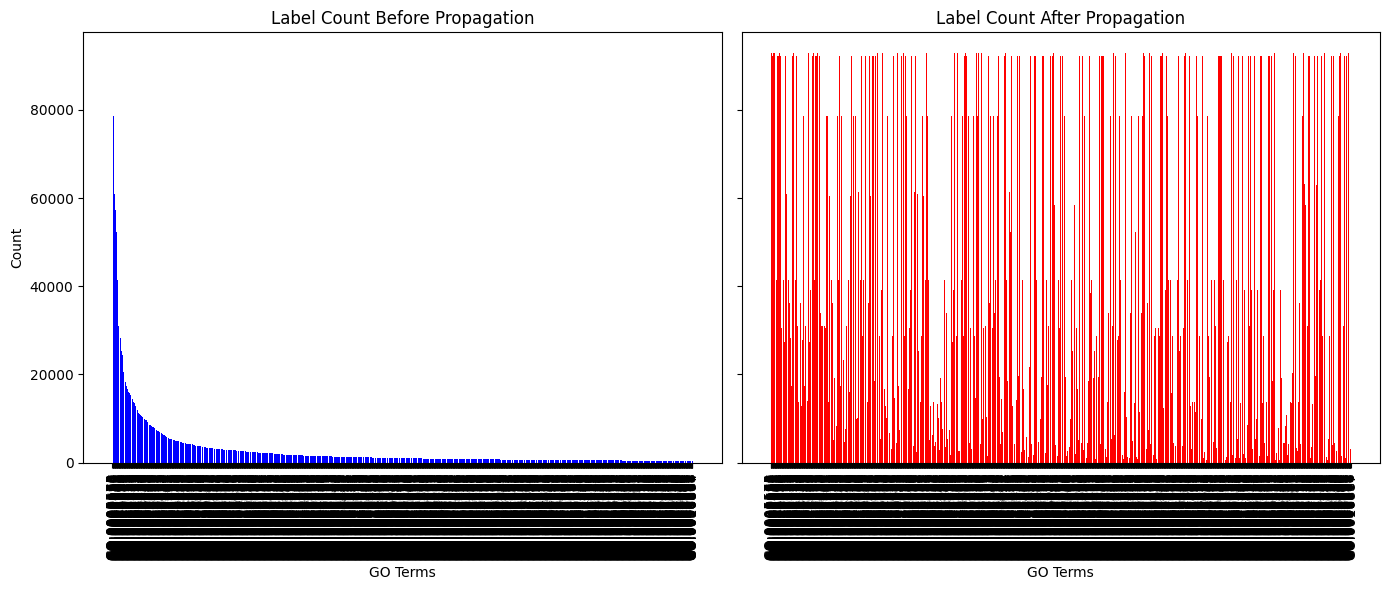

In [ ]:
import matplotlib.pyplot as plt

# Counting labels per column in both DataFrames
label_count_original = df_original.sum(axis=0)
label_count_updated = df_updated.sum(axis=0)

# Setting up the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plotting the original label counts
ax[0].bar(label_count_original.index, label_count_original.values, color='b')
ax[0].set_title('Label Count Before Propagation')
ax[0].set_xlabel('GO Terms')
ax[0].set_ylabel('Count')
ax[0].tick_params(axis='x', rotation=90)

# Plotting the updated label counts
ax[1].bar(label_count_updated.index, label_count_updated.values, color='r')
ax[1].set_title('Label Count After Propagation')
ax[1].set_xlabel('GO Terms')
ax[1].tick_params(axis='x', rotation=90)

# Adjust layout for better visibility
plt.tight_layout()
plt.show()
